# **Twitter: NER NLP**
# **Problem Statement**

Twitter, a widely used social networking platform, generates over 500 million tweets per day. To enhance trend and topic analysis, Twitter aims to automatically tag and analyze tweet content without relying on user-provided hashtags, as users often omit hashtags or use incorrect ones. To solve this, Twitter requires a system that can recognize important content within tweets, tagging entities accurately regardless of hashtags.


# **Importing libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input

import tensorflow_addons as tfa
from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from tensorflow_addons.optimizers import AdamW
from tensorflow_addons.layers import CRF

from nltk.tokenize import word_tokenize

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def load_data(filepath):
    sentences = []
    labels = []
    sentence = []
    label = []
    with open(filepath, "r") as file:
        for line in file:
            if line.strip():  # Non-empty line
                word, tag = line.split()
                sentence.append(word)
                label.append(tag)
            else:
                if sentence:
                    sentences.append(sentence)
                    labels.append(label)
                    sentence = []
                    label = []
    return sentences, labels

# Load the training and test data
train_sentences, train_labels = load_data('/content/drive/MyDrive/NER data/wnut 16.txt.conll')  # Specify correct file path
test_sentences, test_labels = load_data('/content/drive/MyDrive/NER data/wnut 16test.txt.conll')    # Specify correct file path

In [3]:
print("Sample sentence:", train_sentences[0])
print("Sample labels:", train_labels[0])

Sample sentence: ['@SammieLynnsMom', '@tg10781', 'they', 'will', 'be', 'all', 'done', 'by', 'Sunday', 'trust', 'me', '*wink*']
Sample labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [4]:
from collections import Counter
label_counts = Counter([label for labels in train_labels for label in labels])
label_counts

Counter({'O': 44000,
         'B-geo-loc': 276,
         'B-facility': 104,
         'I-facility': 105,
         'B-movie': 34,
         'I-movie': 46,
         'B-company': 171,
         'B-product': 97,
         'B-person': 449,
         'B-other': 225,
         'I-other': 320,
         'B-sportsteam': 51,
         'I-sportsteam': 23,
         'I-product': 80,
         'I-company': 36,
         'I-person': 215,
         'I-geo-loc': 49,
         'B-tvshow': 34,
         'B-musicartist': 55,
         'I-musicartist': 61,
         'I-tvshow': 31})

In [5]:
sentence_lengths = [len(sentence) for sentence in train_sentences]
print("Average sentence length:", sum(sentence_lengths) / len(sentence_lengths))
print("Max sentence length:", max(sentence_lengths))
print("Min sentence length:", min(sentence_lengths))

Average sentence length: 19.415796071876304
Max sentence length: 39
Min sentence length: 1


In [6]:
unique_words = set([word for sentence in train_sentences for word in sentence])
print("Unique words:", len(unique_words))

Unique words: 10585


In [7]:
unique_labels = set([label for labels in train_labels for label in labels])
unique_labels

{'B-company',
 'B-facility',
 'B-geo-loc',
 'B-movie',
 'B-musicartist',
 'B-other',
 'B-person',
 'B-product',
 'B-sportsteam',
 'B-tvshow',
 'I-company',
 'I-facility',
 'I-geo-loc',
 'I-movie',
 'I-musicartist',
 'I-other',
 'I-person',
 'I-product',
 'I-sportsteam',
 'I-tvshow',
 'O'}

# **Data Preprocessing**
## **Label Encoding:**
* Convert string labels into numerical form for model compatibility using LabelEncoder.

## **Tokenization and Padding:**
Use a tokenizer to convert words to numerical indices and pad sentences to a fixed length for batch processing.


In [49]:
label_encoder = LabelEncoder()
all_labels = [label for labels in train_labels for label in labels]
label_encoder.fit(all_labels)

train_labels_encoded = [label_encoder.transform(labels) for labels in train_labels]
test_labels_encoded = [label_encoder.transform(labels) for labels in test_labels]

In [9]:
label_encoder.classes_

array(['B-company', 'B-facility', 'B-geo-loc', 'B-movie', 'B-musicartist',
       'B-other', 'B-person', 'B-product', 'B-sportsteam', 'B-tvshow',
       'I-company', 'I-facility', 'I-geo-loc', 'I-movie', 'I-musicartist',
       'I-other', 'I-person', 'I-product', 'I-sportsteam', 'I-tvshow',
       'O'], dtype='<U13')

In [10]:
# Check encoded labels
print("Encoded Sample Labels:", train_labels_encoded[0])

Encoded Sample Labels: [20 20 20 20 20 20 20 20 20 20 20 20]


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)

train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

max_len = max(sentence_lengths)
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

train_labels_padded = pad_sequences(train_labels_encoded, maxlen=max_len, padding='post', value=-1)
test_labels_padded = pad_sequences(test_labels_encoded, maxlen=max_len, padding='post', value=-1)

In [12]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

In [13]:
print("Padded sentence shape:", train_sequences_padded.shape)
print("Padded labels shape:", train_labels_padded.shape)

Padded sentence shape: (2393, 39)
Padded labels shape: (2393, 39)


## **Training an LSTM + CRF Model**
* We'll start by initializing embeddings using Word2Vec and prepare data for LSTM+CRF.

In [14]:
from gensim.models import Word2Vec

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create an embedding matrix using the Word2Vec model
embedding_dim = 100  # Use the same dimensionality as Word2Vec embeddings
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[idx] = word2vec_model.wv[word]

In [15]:
# Define LSTM+CRF Model
def create_lstm_crf_model(input_shape, n_labels, embedding_matrix=None):
    # Define input layer for tokenized sequences
    input_ids = Input(shape=input_shape)

    # Embedding layer with pre-trained embeddings
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],  # Use pre-trained embeddings
                                input_length=input_shape[0],
                                trainable=False)(input_ids)

    # variational biLSTM
    output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(embedding_layer)

    # Stacking
    output_sequences = Bidirectional(LSTM(units=50, return_sequences=True))(output_sequences)

    # Dropout layer for regularization
    dropout_layer = Dropout(0.1)(output_sequences)

    # CRF layer for sequence labeling
    crf_layer = tfa.layers.CRF(n_labels)
    # Modify this line to unpack all 4 return values
    crf_out, potentials, sequence_length, chain_kernel = crf_layer(dropout_layer) # unpack all 4 return values of crf_layer

    # Build and compile model with CRF loss
    model = Model(inputs=input_ids, outputs=potentials)
    # Change the loss function to crf_layer.loss
    model.compile(optimizer=AdamW(weight_decay=0.001), loss=SigmoidFocalCrossEntropy(), metrics=['accuracy'])

    return model

In [16]:
# Model parameters
input_shape = (train_sequences_padded.shape[1],)
n_labels = len(label_encoder.classes_)

# Create and display the model
model = create_lstm_crf_model(input_shape=input_shape, n_labels=n_labels+1, embedding_matrix=embedding_matrix)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 embedding (Embedding)       (None, 39, 100)           906900    
                                                                 
 bidirectional (Bidirection  (None, 39, 100)           60400     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 39, 100)           60400     
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 39, 100)           0         
                                                                 
 crf (CRF)                   [(None, 39),              2750  

# **Train-Test Split for Model**

In [17]:
X_train, X_val, y_train, y_val = train_test_split(train_sequences_padded, train_labels_padded, test_size=0.2, random_state=42)

In [18]:
y_train_onehot = to_categorical(y_train, num_classes=n_labels+1)
y_val_onehot = to_categorical(y_val, num_classes=n_labels+1)

# Now fit the model using the one-hot encoded labels:
history = model.fit(X_train, y_train_onehot,
                    validation_data=(X_val, y_val_onehot),
                    epochs=5, batch_size=32)

Epoch 1/5


60/60 [==============================] - 14s 47ms/step - loss: 0.2602 - accuracy: 0.8508 - val_loss: 0.0819 - val_accuracy: 0.9317
Epoch 2/5
60/60 [==============================] - 1s 15ms/step - loss: 0.0852 - accuracy: 0.9357 - val_loss: 0.0862 - val_accuracy: 0.9332
Epoch 3/5
60/60 [==============================] - 1s 14ms/step - loss: 0.0700 - accuracy: 0.9383 - val_loss: 0.0587 - val_accuracy: 0.9355
Epoch 4/5
60/60 [==============================] - 1s 14ms/step - loss: 0.0599 - accuracy: 0.9401 - val_loss: 0.0561 - val_accuracy: 0.9365
Epoch 5/5
60/60 [==============================] - 1s 14ms/step - loss: 0.0993 - accuracy: 0.8781 - val_loss: 0.0653 - val_accuracy: 0.9362


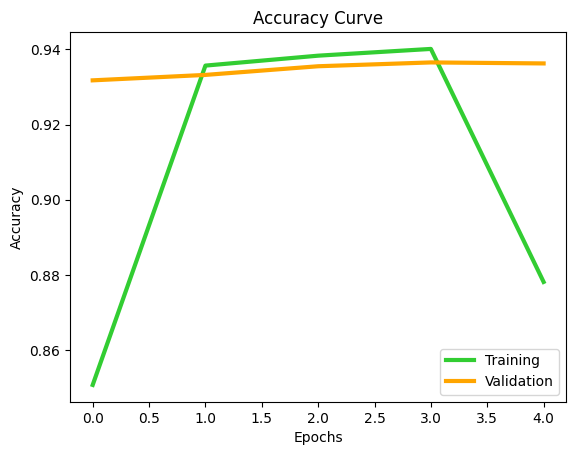

In [19]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.plot(history.history['accuracy'],linewidth=3,color='limegreen')
plt.plot(history.history['val_accuracy'],linewidth=3,color='orange')  # Plot the chart
plt.legend(["Training", "Validation"], loc ="lower right")

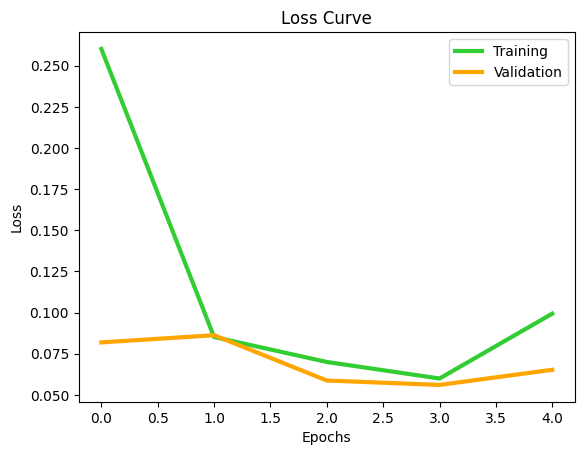

In [20]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.plot(history.history['loss'],linewidth=3,color='limegreen')
plt.plot(history.history['val_loss'],linewidth=3,color='orange')  # Plot the chart
plt.legend(["Training", "Validation"], loc ="upper right")

In [21]:
model.compile(optimizer=AdamW(weight_decay=0.001), loss=SigmoidFocalCrossEntropy(), metrics=['accuracy'])
test_labels_padded_onehot = to_categorical(test_labels_padded, num_classes=n_labels+1)

# Now evaluate the model and unpack the results
test_loss, test_acc = model.evaluate(test_sequences_padded, test_labels_padded_onehot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

121/121 [==============================] - 5s 7ms/step - loss: 0.1585 - accuracy: 0.8412
Test Loss: 0.1585441380739212, Test Accuracy: 0.8411575555801392


## **BERT Tokenizer**

In [22]:
from transformers import BertTokenizer, TFBertForTokenClassification, TFBertForSequenceClassification

In [23]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = TFBertForTokenClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_)+1)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Define maximum sequence length (for padding and truncation)
max_len = 75

# Tokenization function
def tokenize_and_align_labels(sentences, labels):
    input_ids = []
    attention_masks = []
    label_ids = []

    for sentence, label in zip(sentences, labels):
        tokenized_inputs = tokenizer(sentence, truncation=True, padding='max_length', max_length=max_len, is_split_into_words=True)
        input_ids.append(tokenized_inputs['input_ids'])
        attention_masks.append(tokenized_inputs['attention_mask'])

        label_ids_tmp = [21] * max_len
        numerical_labels = [int(label_i) for label_i in label_encoder.transform(label)]  # Convert to integers
        label_ids_tmp[:len(numerical_labels)] = numerical_labels[:len(numerical_labels)]
        label_ids.append(label_ids_tmp)


    return np.array(input_ids), np.array(attention_masks), np.array(label_ids)

# Tokenize and prepare the data for training and testing
train_input_ids, train_attention_masks, train_label_ids = tokenize_and_align_labels(train_sentences, train_labels)
test_input_ids, test_attention_masks, test_label_ids = tokenize_and_align_labels(test_sentences, test_labels)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(train_input_ids, train_label_ids, test_size=0.2, random_state=42)

In [26]:
from transformers import AdamWeightDecay

optimizer = AdamWeightDecay(learning_rate=3e-5)
# Create a custom loss function to handle the ignore_index
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    # Create a mask to identify the padded tokens
    mask = tf.math.not_equal(y_true, 21)

    # Calculate the loss, applying the mask
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    masked_loss = tf.boolean_mask(loss, mask)

    # Return the mean of the masked loss
    return tf.reduce_mean(masked_loss)

# Use the custom loss function
model.compile(optimizer=optimizer, loss=masked_sparse_categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  16918     
                                                                 
Total params: 108908566 (415.45 MB)
Trainable params: 108908566 (415.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
model_name = "/content/drive/MyDrive/NER data/bert_ner_model"
save_model = tf.keras.callbacks.ModelCheckpoint(filepath=model_name,
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)

EarlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [43]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=32, callbacks=[save_model, EarlyStoppingCallback])

Epoch 1/5
60/60 [==============================] - ETA: 0s - loss: 0.1019 - accuracy: 0.2513
Epoch 1: val_loss improved from inf to 0.34368, saving model to /content/drive/MyDrive/NER data/bert_ner_model
60/60 [==============================] - 44s 737ms/step - loss: 0.1019 - accuracy: 0.2513 - val_loss: 0.3437 - val_accuracy: 0.2415
Epoch 2/5
60/60 [==============================] - ETA: 0s - loss: 0.0804 - accuracy: 0.2531
Epoch 2: val_loss did not improve from 0.34368
60/60 [==============================] - 32s 536ms/step - loss: 0.0804 - accuracy: 0.2531 - val_loss: 0.3479 - val_accuracy: 0.2421
Epoch 3/5
60/60 [==============================] - ETA: 0s - loss: 0.0665 - accuracy: 0.2541
Epoch 3: val_loss did not improve from 0.34368
60/60 [==============================] - 31s 523ms/step - loss: 0.0665 - accuracy: 0.2541 - val_loss: 0.3553 - val_accuracy: 0.2439
Epoch 4/5
60/60 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.2548
Epoch 4: val_loss did not i

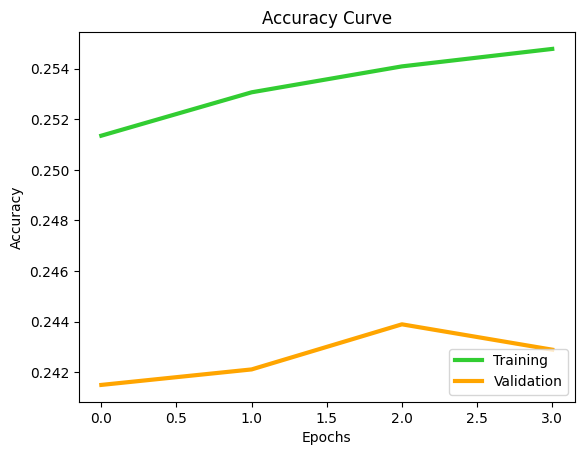

In [44]:
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.plot(history.history['accuracy'],linewidth=3,color='limegreen')
plt.plot(history.history['val_accuracy'],linewidth=3,color='orange')  # Plot the chart
plt.legend(["Training", "Validation"], loc ="lower right")

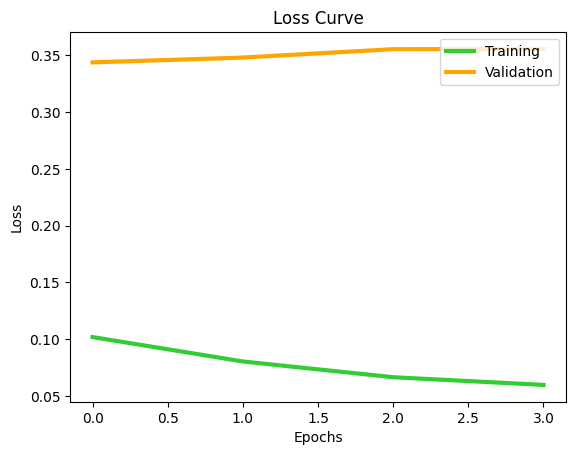

In [45]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.plot(history.history['loss'],linewidth=3,color='limegreen')
plt.plot(history.history['val_loss'],linewidth=3,color='orange')  # Plot the chart
plt.legend(["Training", "Validation"], loc ="upper right")

In [31]:
# Align predictions for sub-tokens
def align_output(tokens, predictions):
    # Merge sub-token predictions to the full token
    aligned_predictions = []
    for token, prediction in zip(tokens, predictions):
        aligned_predictions.append((token, prediction))  # Implement your merging logic here
    return aligned_predictions

In [32]:
# Make predictions
predictions = model.predict(y_train)
aligned_predictions = align_output(test_sentences, predictions)
aligned_predictions

60/60 [==============================] - 21s 177ms/step


[(['New',
   'Orleans',
   'Mother',
   "'s",
   'Day',
   'Parade',
   'shooting',
   '.',
   'One',
   'of',
   'the',
   'people',
   'hurt',
   'was',
   'a',
   '10-year-old',
   'girl',
   '.',
   'WHAT',
   'THE',
   'HELL',
   'IS',
   'WRONG',
   'WITH',
   'PEOPLE',
   '?'],
  'logits')]

In [33]:
model.save_pretrained("/content/drive/MyDrive/NER data/bert_ner_model")

In [48]:
# Sample sentence
sample_sentence = ["Harry Potter is a wizard."]
max_len = 128

# Tokenize the data
input_data = tokenizer(
    sample_sentence,
    truncation=True,
    padding="max_length",
    max_length=max_len,
    is_split_into_words=True,
    return_tensors="tf"
)

# Get predictions from the model
predictions = model(input_data)

# Map the logits to predicted labels
id_to_label = {i: label for i, label in enumerate(label_encoder.classes_)}
predicted_labels = [id_to_label[np.argmax(logit)] for logit in predictions.logits[0].numpy()]

# Filter out padding tokens using attention_mask
attention_mask = input_data['attention_mask'].numpy()[0]  # Get attention_mask for the first sentence
actual_length = sum(attention_mask)  # Count the number of '1's, which correspond to real tokens

print("Predicted labels (without filtering):", predicted_labels)
print("Length of actual sentence output:", actual_length)

# Optional: Filter out padding labels if you only want the relevant predictions
filtered_labels = [label for label, mask in zip(predicted_labels, attention_mask) if mask == 1]
print("Filtered labels:", filtered_labels)
print("Length of filtered labels:", len(filtered_labels))


Predicted labels (without filtering): ['B-person', 'I-person', 'O', 'O', 'O', 'O', 'O', 'B-person', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Length of actual sentence output: 8
Filtered labels: ['B-person', 'I-person', 'O', 'O', 'O', 'O', 'O', 'B-person']
Length of filtered labels: 8


# **Questions**

1. Defining the problem statements and where can this and modifications of this be used?
* **Problem Statements:**
  * Extract entities like names, locations, or companies from unstructured text data.
  * Automate Named Entity Recognition (NER) to improve understanding of user-generated content like tweets.
  * Classify fine-grained categories such as person, geo-location, and company.
* **Use Cases:**
  * **Social Media Monitoring:** Track mentions of specific people, places, or brands.
  * **Customer Support Automation:** Identify key entities in user queries for better response automation.
  * **Content Categorization:** Organize content by identifying relevant categories.
  * **Search Engine Optimization:** Enable more relevant search results by tagging entities in search queries.
  * **Healthcare:** Extract patient information, diagnoses, or symptoms from unstructured clinical notes.
---
2. Explain the data format (conll bio format)

  The CoNLL BIO format is a standard for labeling words in sequences:
  * Each line contains a word and its corresponding label separated by a space
  * Sentences are separated by an empty line.
  * The labels use the BIO format:
    1. B-Entity: Beginning of an entity.
    2. I-Entity: Inside an entity.
    3. O: Outside any entity.
---
3. What other ner data annotation formats are available and how are they different?

* **BIO:** Labels entities with "Begin", "Inside", and "Outside".
* **IOB:** Similar to BIO but does not use "B" for a single entity, making it simpler.
* **IOBES:** Adds "E" for the end of entities and "S" for single-token entities. More explicit than BIO.
* **XML/JSON:** Annotates entities within markup tags or as JSON objects. Ideal for structured data storage.

* **Difference:**
  * BIO and IOB focus on sequence tagging, while IOBES adds granularity for better training. XML and JSON are used for flexible data storage.
---
4. Why do we need tokenization of the data in our case

  Tokenization splits sentences into smaller units (tokens). This is necessary because:
  * Models like BERT operate at the token level.
  * It handles variations like subwords, punctuation, and casing.
  * Ensures alignment between input text and labels (e.g., handling multi-token words).
  * Facilitates mapping between tokens and embeddings during training.
---
5. What other models can you use for this task

* **LSTM + CRF:** Handles sequential data with an additional CRF layer for structured prediction.
* **BiLSTM:** Processes text in both forward and backward directions for context.
* **Transformer-Based Models:**
  * BERT (Bidirectional Encoder Representations from Transformers).
  * RoBERTa (Robustly Optimized BERT).
  * GPT series (Generative Pre-trained Transformers).
* **SpaCy:** Pre-trained models for quick and scalable NER tasks.
* **Flair:** Contextual string embeddings tailored for NER.
---

6. Did early stopping have any effect on the training and results.

  Yes, early stopping prevents overfitting by halting training when validation performance stops improving.
  * **Effect:**
    * Avoids wasting computational resources.
    * Helps retain a model state with optimal generalization capabilities.
    * Reduces the risk of overfitting noisy data.
---

7. How does the BERT model expect a pair of sentences to be processed?

  BERT processes sentence pairs by:
  * Adding a special [CLS] token at the beginning of the first sentence.
  * Adding a [SEP] token to separate the two sentences.
  * Encoding positional embeddings to distinguish between sentences.
  * Using segment embeddings (0 for the first sentence, 1 for the second sentence).
---

8. Why choose Attention based models over Recurrent based ones?
  
  Attention-Based Models:
  * Capture long-range dependencies effectively without vanishing gradients.
  * Parallelizable, enabling faster training.
  * Handle entire sequences simultaneously.
  
  Recurrent Models (RNNs/LSTMs):
  * Process sequentially, making them slower.
  * Struggle with long-range dependencies.

  **Result:** Attention-based models (like Transformers) are more efficient and scalable.


---

9. Differentiate BERT and simple transformers

  BERT (Base Model):
  * A pre-trained transformer model for masked language modeling and next-sentence prediction.
  * Requires extensive configuration for downstream tasks like NER.

  Simple Transformers:
  * A high-level wrapper for transformer models (including BERT).
  * Simplifies fine-tuning for specific tasks (NER, text classification).
  * Reduces boilerplate code and increases accessibility for non-experts.